# I) Summary

**DISCLAIMER**: We will use a simplier version of the LeNet-5 than the one in the [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). (For example, computation on average pooling layers described in the paper are slightly more complex than usual).

LeNet-5 has:

- 2 Convolutional layers.
- 3 Fully connected layers.
- 2 Average pooling layers.
- Tanh as activation function for hidden layer.
- Softmax as activation function for output layer.
- 60000 trainable parameters.

LeNet-5 is:

- trained on MNIST dataset (60000 training examples).
- trained over 20 epoch.
- expected to converge after 10-12 epoch.
- expected to have an error rate of 0.95% on test set.

# II) Implementation

In [166]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

## a) Loading dataset

In [167]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_val, y_val = X_train[55000:, ..., np.newaxis], y_train[55000:]
X_train, y_train = X_train[:55000, ..., np.newaxis], y_train[:55000]
X_test =  X_test[..., np.newaxis]

print("Image Shape: {}".format(X_train[0].shape), end = '\n\n')
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set:   {} samples".format(len(X_val)))
print("Test Set:       {} samples".format(len(X_test)))

Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set:   5000 samples
Test Set:       10000 samples


## b) Preprocessing

We need to:

- reshape the image into a 32x32x1 shape.
- normalize the dataset.

In [168]:
# Pad images with 0s
X_train = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_val = np.pad(X_val, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

print("Updated Image Shape for: ", end='\n\n')
print("-Training set: {}".format(X_train.shape))
print("-Validation set: {}".format(X_val.shape))
print("-Test set: {}".format(X_test.shape))

Updated Image Shape for: 

-Training set: (55000, 32, 32, 1)
-Validation set: (5000, 32, 32, 1)
-Test set: (10000, 32, 32, 1)


In [169]:
#Normalization.
X_train, X_val, X_test = X_train/float(255), X_val/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_val -= np.mean(X_val)
X_test -= np.mean(X_test)

## c) Visualization

In [170]:
def plot_images(X, y, y_pred=None):
    """
        Plots 9 Plot the 9 images and labels.
        
        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    """
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
 
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(X[i])

        # Show true and predicted classes.
        if y_pred is None:
            xlabel = "True: {0}".format(y[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(y[i], y_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

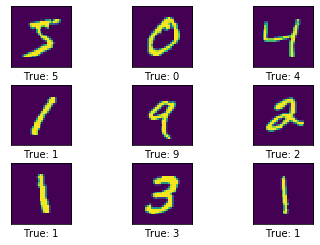

In [171]:
plot_images(X_train[0:9, :, :, 0], y_train[0:9])

## d) Architecture build

In [172]:
def create_placeholders():
    """
        Creates the placeholders for the tensorflow session.
        
        Returns:
        -X: placeholder for the data input of shape [None, 32, 32, 1] and dtype "float".
        -y: placeholder for the input labels of shape [None] and dtype "float".
    """
    X = tf.placeholder(tf.float32, (None, 32, 32, 1), name='X')
    y = tf.placeholder(tf.int32, (None), name='labels')

    return X, y

In [173]:
def initialize_parameters():
    """
        Initializes weights and biases parameters using xavier initialization.
        
        Returns:
        -parameters: A dictionary of tensors containing the weights and biases. 
    """
    
    C1_w = tf.get_variable("C1_w",shape = [5,5,1,6], initializer = tf.contrib.layers.xavier_initializer())
    C2_w = tf.get_variable("C2_w",shape = [5,5,6,16], initializer = tf.contrib.layers.xavier_initializer())
    F1_w = tf.get_variable("F1_w",shape = [400,120], initializer = tf.contrib.layers.xavier_initializer())
    F2_w = tf.get_variable("F2_w",shape = [120,84], initializer = tf.contrib.layers.xavier_initializer())
    F3_w = tf.get_variable("F3_w",shape = [84,10], initializer = tf.contrib.layers.xavier_initializer())

    C1_b = tf.get_variable("C1_b", shape = [6], initializer = tf.zeros_initializer())
    C2_b = tf.get_variable("C2_b", shape = [16], initializer = tf.zeros_initializer())
    F1_b = tf.get_variable("F1_b", shape = [120], initializer = tf.zeros_initializer())
    F2_b = tf.get_variable("F2_b", shape = [84], initializer = tf.zeros_initializer())
    F3_b = tf.get_variable("F3_b", shape = [10], initializer = tf.zeros_initializer())
        
    parameters = {'C1_w': C1_w, 'C1_b': C1_b,
                  'C2_w': C2_w, 'C2_b': C2_b,
                  'F1_w': F1_w, 'F1_b': F1_b,
                  'F2_w': F2_w, 'F2_b': F2_b,
                  'F3_w': F3_w, 'F3_b': F3_b}
    
    return parameters

In [174]:
def forward_propagation(X, parameters):
     
    #Forward propagation.
    
    with tf.name_scope('conv1'):
        #(None,32,32,1) -> (None,28,28,6).
        C1 = tf.nn.conv2d(X, parameters['C1_w'], strides=[1,1,1,1], padding='VALID') + parameters['C1_b']
        A1 = tf.nn.tanh(C1)
        #(None,28,28,6) -> (None,14,14,6).
        P1 = tf.nn.avg_pool(A1, ksize=(1,2,2,1), strides = (1,2,2,1), padding='VALID')
   
    with tf.name_scope('conv2'):
        #(None,14,14,6) -> (None,10,10,16).
        C2 = tf.nn.conv2d(P1, parameters['C2_w'], strides=[1,1,1,1], padding='VALID') + parameters['C2_b']
        A2 = tf.nn.tanh(C2)
        #(None,10,10,16) -> (None,5,5,16).
        P2 = tf.nn.avg_pool(A2, ksize=(1,2,2,1), strides = (1,2,2,1), padding='VALID')
    
    with tf.name_scope('flatten'):
        #(None,5,5,16) -> (None, 400, 1).
        P2_flatten = tf.contrib.layers.flatten(P2)
    
    with tf.name_scope('fc1'):
        #(None, 400,1) -> (None,120,1).
        F1 = tf.matmul(P2_flatten, parameters['F1_w']) + parameters['F1_b']
        A3 = tf.nn.tanh(F1)
    
    with tf.name_scope('fc2'):
        #(None,120,1) -> (None,84,1).
        F2 = tf.matmul(A3, parameters['F2_w']) + parameters['F2_b']
        A4 = tf.nn.tanh(F2)
    
    with tf.name_scope('fc3'):
        #(None,84,1) -> (None,10,1)
        F3 = tf.matmul(A4, parameters['F3_w']) + parameters['F3_b']

    return F3

In [175]:
def compute_cost(y_pred, y):
    with tf.name_scope('xent'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_pred, labels = tf.one_hot(y, 10)))
        return cost

In [184]:
# def evaluate(X_data, y_data):
#         num_examples = len(X_data)
#         total_accuracy = 0
#         sess = tf.get_default_session()
#         for offset in range(0, num_examples, BATCH_SIZE):
#             end = offset+BATCH_SIZE
#             batch_x, batch_y = X_data[offset:end], y_data[offset:end]
#             accuracy = sess.run(accuracy_operation, feed_dict={X: batch_x, y: batch_y})
#             total_accuracy += (accuracy * len(batch_x))
#         return total_accuracy / num_examples

In [200]:
def LeNet_5():
    tf.reset_default_graph()
    nb_examples = X_train.shape[0]
    NB_EPOCHS, BATCH_SIZE, LR = 20, 128, 0.001
    nb_batches = int(nb_examples / BATCH_SIZE)
    
    # Create Placeholders of the correct shape.
    X, y = create_placeholders()
    
    # Initialize parameters.
    parameters = initialize_parameters()
    
    #Build the forward propagation in the tensorflow graph.
    y_pred = forward_propagation(X, parameters)
    
    #Add cost function to tensorflow graph.
    cost = compute_cost(y_pred, y)
    
    #Define the tensorflow optimizer.
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate = LR).minimize(cost)
    
    #
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(tf.one_hot(y, 10), 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    def evaluate(X_data, y_data):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset+BATCH_SIZE
            batch_x, batch_y = X_data[offset:end], y_data[offset:end]
            accuracy = sess.run(accuracy_operation, feed_dict={X: batch_x, y: batch_y})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples
    
    with tf.Session() as sess:
        # Create event file in order to display graph on tensorboard.
        #writer = tf.summary.FileWriter("logs", sess.graph)
        #writer.close()
        
        # Initialize all the variables globally.
        init = tf.global_variables_initializer()
        
        # Run the initialization
        sess.run(init)

        for epoch in range(NB_EPOCHS):

            batch_cost, total_accuracy, = 0, 0
            
            for offset in range(0, nb_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                X_batch, y_batch = X_train[offset:end], y_train[offset:end]
                
                _,temp_cost = sess.run(fetches = [optimizer,cost], feed_dict={X:X_batch, y:y_batch})
               
                batch_cost += temp_cost / nb_batches
               
            val_accuracy = evaluate(X_val, y_val)
            print("[Epoch {}/{}]: Cost = {} | Validation accuracy = {}".format(epoch+1, NB_EPOCHS, batch_cost, val_accuracy))
    
        #Make prediction.
        predictions = sess.run(y_pred, feed_dict={X: X_test})
        
        return predictions

In [201]:
predictions = LeNet_5()

KeyboardInterrupt: 

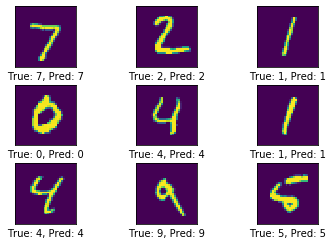

In [202]:
plot_images(X_test[0:9, :, :, 0], y_test[0:9], np.argmax(predictions, axis=1)[0:9])

Display possible errors (youtube channel of the guy)

# III) Conclusion